In [ ]:
!unzip ./drive/MyDrive/single-person-pose-estimation/dataset/tfrecords.zip

Archive:  ./drive/MyDrive/single-person-pose-estimation/dataset/tfrecords.zip
   creating: dataset/tfrecords/
   creating: dataset/tfrecords/valid/
  inflating: dataset/tfrecords/valid/file_valid_02-1551.tfrec  
  inflating: dataset/tfrecords/valid/file_valid_01-2048.tfrec  
  inflating: dataset/tfrecords/valid/file_valid_00-2048.tfrec  
   creating: dataset/tfrecords/train/
  inflating: dataset/tfrecords/train/file_train_21-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_00-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_47-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_50-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_25-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_20-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_62-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_52-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_36-2048.tfrec  
  inflating: dataset/tfrecords/train/file_trai

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('/content/drive/MyDrive/single-person-pose-estimation')
from configs import default_config as cfg
from model.hourglass import create_hourglass_model
from dataset_builder import DatasetBuilder
from utils import compile_model_from_checkpoint
import tensorflow.keras.backend as K

In [ ]:
model = create_hourglass_model(cfg.NUM_KEYPOINTS, 
                                 cfg.HG_NUM_STACKS,
                                 cfg.HG_NUM_CHANNELS,
                                 cfg.IMAGE_SHAPE,
                                 cfg.HM_ACTIVATION)
model = compile_model_from_checkpoint(model, '/content/drive/MyDrive/storage/3/checkpoints/best_val_loss_weights.ckpt',
                                 optimizer = tf.keras.optimizers.Adam(),
                                 loss = tf.keras.losses.MeanSquaredError())

Created Hourglass model:
    1. 2 stacks.
    2. 7034530 parameters. Call model.get_summary() for more detail.
    


In [ ]:
ds_builder = DatasetBuilder(cfg)

Train dataset with 66 tfrecords and 134214 examples.
Valid dataset with 3 tfrecords and 5647 examples.


In [ ]:
ds = ds_builder.get_ds_prediction()

In [ ]:
it = iter(ds)

In [ ]:
imgs_batch, meta = next(it)

In [ ]:
predictions = model.predict(imgs_batch)

In [ ]:
predictions = predictions[-1]
predictions.shape

(16, 64, 64, 17)

In [ ]:
true_kps_x = []
true_kps_y = []
for i in range(16):
  kps_x = meta['keypoints/x'][i] 
  kps_y = meta['keypoints/y'][i]
  h = tf.cast(meta['original_height'][i], tf.float32)
  w = tf.cast(meta['original_width'][i], tf.float32)
  true_kps_x.append((kps_x/w)*64)
  true_kps_y.append((kps_y/w)*64)

In [ ]:
hms_batch = np.array([ds_builder.np_gen_heatmaps(xs, ys) for xs, ys in zip(true_kps_x, true_kps_y)])

In [ ]:
hms_batch.shape

(16, 64, 64, 17)

Text(0.5, 1.0, 'Predicted')

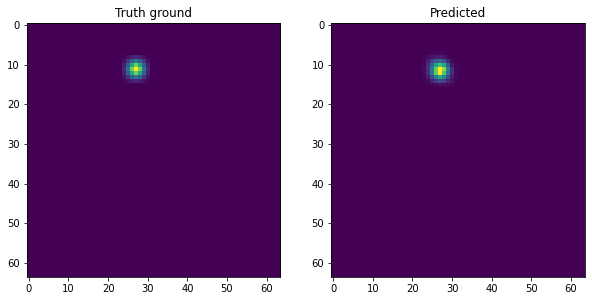

In [ ]:
fig = plt.figure(figsize=(10, 10))
rows = 1
cols = 2

fig.add_subplot(rows, cols, 1)
plt.imshow(hms_batch[0, :, :, 0])
plt.title('Truth ground')

fig.add_subplot(rows, cols, 2)
plt.imshow(predictions[0, :, :, 0])
plt.title('Predicted')



---

MSE

In [ ]:
mse = tf.keras.losses.mean_squared_error
tf.math.reduce_mean(mse(hms_batch, predictions))

<tf.Tensor: shape=(), dtype=float32, numpy=0.0007658397>



---
Weighted MSE


In [ ]:
def weighted_mean_squared_error(y_true, y_pred):
  ''' Both inputs should has the same shape (batch_size, d0, d1, .. dN)
  Args:
    y_true: labels
    y_pred: predictions
  Returns:
    A tensor with shape (batch_size, d0, d1, .. dN-1) -> reduced last axis
    It should NOT return a scalar
  Raises:

  '''
  # weights has the same shape y_true and y_pred
  weights = tf.cast(y_true > 0, dtype = tf.float32)*81 + 1
  
  # check if the keypoint is valid, heatmap_sum has the shape of (batch_size, 1, 1, number of keypoint)
  heatmap_sum = tf.math.reduce_sum(y_true, axis= [1, 2], keepdims=True)
  # valid keypoint = 1.0, invalid = 0.0
  keypoint_weights = 1.0 - tf.cast(tf.equal(heatmap_sum, 0.0), tf.float32)

  return tf.reduce_mean(tf.math.square(y_true - y_pred) * weights , axis = -1)

In [ ]:
hm_sum = tf.math.reduce_sum(tf.math.reduce_sum(hms_batch, axis=1, keepdims=True), axis=2, keepdims=True)
hm_sum.shape

TensorShape([16, 1, 1, 17])

In [ ]:
keypoint_weights = 1.0 - tf.cast(tf.equal(hm_sum, 0.0), tf.float32)
keypoint_weights[0, :, :, 0]

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>

In [ ]:
print(tf.math.reduce_mean(weighted_mean_squared_error(hms_batch, predictions)))

tf.Tensor(0.04514058, shape=(), dtype=float32)


In [ ]:
# with keypoint-weights 0.04510104
# without               0.04514058,



---

IOU

In [ ]:
hm_sum = tf.math.reduce_sum(hms_batch, axis = [1, 2])
hm_sum.shape

TensorShape([16, 17])

In [ ]:
def IOU(y_true, y_pred):
  epsilon = 1e-6
  inter = tf.reduce_sum(y_true*y_pred, axis = [1, 2])
  union = tf.reduce_sum(y_true*y_true, axis = [1, 2]) + tf.reduce_sum(y_pred*y_pred, axis = [1, 2]) - inter
  IoU = (inter + epsilon) / (union + epsilon)
  return 1 - tf.reduce_mean(IoU, axis = -1)

In [ ]:
print(tf.shape(IOU(hms_batch, predictions)))

tf.Tensor([16], shape=(1,), dtype=int32)




---

ds 